In [2]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
import matplotlib.pyplot as plt
from glob import glob
import os
from PIL import Image
from functools import partial
import pandas as pd
from utils import load_dataset, predict, plot_results
from utils import get_enhanced_image
import cv2

In [6]:
from model import dce_net
from loss_functions import SpatialConsistencyLoss

In [18]:
try:
    img = load_dataset(["test_imgs/harsh.jpg"])
    print("Image is succesfully loaded.", img.shape)
except Exception as e:
    print("Image is not able to loaded. Please try again.")
    exit()

model = dce_net(SpatialConsistencyLoss())
params = pd.read_pickle("dce_net_params.pkl")
outputs = model.apply(params, img)
enhanced_imgs = get_enhanced_image(img, outputs)
# enhanced_img = predict(model, params, img)
cv2.imwrite("test_imgs/enhanced_img.png", enhanced_imgs[0].to_py()*255)

Image is succesfully loaded. (1, 256, 256, 3)


True

In [16]:
jnp.sum(enhanced_imgs[0].to_py() == enhanced_imgs[0])

DeviceArray(196608, dtype=int32)

In [11]:
enhanced_imgs[0]

DeviceArray([[[0.9898019 , 0.09515803, 0.9966126 ],
              [0.98992765, 0.17887855, 0.996357  ],
              [0.9883978 , 0.2549913 , 0.9963002 ],
              ...,
              [0.        , 0.25286913, 0.8666154 ],
              [0.09269691, 0.2509521 , 0.8656977 ],
              [0.        , 0.17688067, 0.87316775]],

             [[0.9903301 , 0.25400928, 0.9964831 ],
              [0.9895644 , 0.18655032, 0.9960821 ],
              [0.98772055, 0.26277483, 0.9959516 ],
              ...,
              [0.09363995, 0.25091898, 0.89438546],
              [0.09365094, 0.2515738 , 0.8940115 ],
              [0.0939751 , 0.2513654 , 0.89966094]],

             [[0.9910399 , 0.2480222 , 0.996689  ],
              [0.9898039 , 0.18241161, 0.99624914],
              [0.9872485 , 0.25493327, 0.9961414 ],
              ...,
              [0.09329479, 0.17839706, 0.90982705],
              [0.09317251, 0.17846292, 0.91441256],
              [0.09351827, 0.17774978, 0.909245  ]],

 

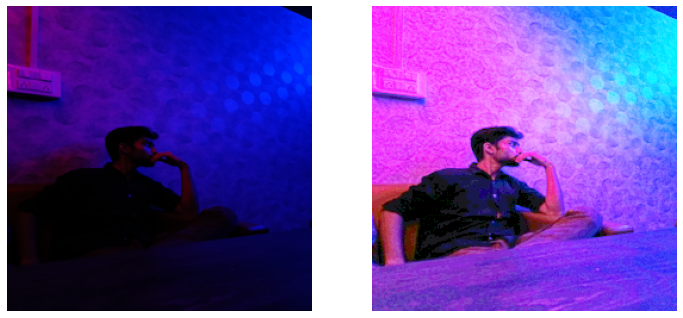

In [10]:
plt.ion()
plot_results([img[0], enhanced_imgs[0]])
plt.show()

In [20]:
names = glob(os.path.join("datasets/lol_dataset/our485/low", "*.png"))

In [21]:
def load(name):
    img = Image.open(name)
    img = img.resize((256,256))
    return jnp.array(img)/255

In [22]:
imgs = jnp.array(list(map(load, names)))

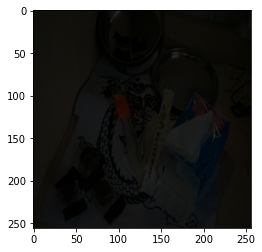

In [13]:
idx = 234
plt.imshow(imgs[idx])

In [23]:
def get_enhanced_image(org_img, output):
        for i in range(0, 3 * 8, 3):
            r = output[:, :, :, i: i + 3]
            org_img = org_img + r * (jnp.square(org_img) - org_img)
        return org_img

In [24]:
def color_constancy_loss(x):
    mean_rgb = jnp.mean(x, axis=(1, 2), keepdims=True)
    mean_red = mean_rgb[:, :, :, 0]
    mean_green = mean_rgb[:, :, :, 1]
    mean_blue = mean_rgb[:, :, :, 2]
    diff_red_green = jnp.square(mean_red - mean_green)
    diff_red_blue = jnp.square(mean_red - mean_blue)
    diff_green_blue = jnp.square(mean_blue - mean_green)
    return jnp.sqrt(
        jnp.square(diff_red_green) + jnp.square(diff_red_blue) + jnp.square(diff_green_blue)
    )

In [25]:
def exposure_loss(x, mean_val=0.6):
    x = jnp.mean(x, axis=3, keepdims=True)
    mean = nn.avg_pool(x, (16,16), strides=(16,16))
    return jnp.mean(jnp.square(mean - mean_val))

In [26]:
def illumination_smoothness_loss(x):
    batch_size = x.shape[0]
    height_x = x.shape[1]
    width_x = x.shape[2]
    
    count_height = (width_x - 1)*x.shape[3]
    count_width = width_x*(x.shape[3] - 1)
    
    heigth_total_variance = jnp.sum(jnp.square(x[:, 1:, :, :] - x[:, :height_x - 1, :, :]))
    width_total_variance = jnp.sum(jnp.square(x[:, :, 1:, :] - x[:, :, :width_x - 1, :]))
    
    return 2*(heigth_total_variance/count_height  + width_total_variance/count_width)/batch_size

In [27]:
class SpatialConsistencyLoss():
    def __init__(self):
        self.conv = partial(nn.Conv, features=1, kernel_size=(3,3))
        self.left_conv = self.conv(kernel_init=self.init_lk)
        self.right_conv = self.conv(kernel_init=self.init_rk)
        self.up_conv = self.conv(kernel_init=self.init_uk)
        self.down_conv = self.conv(kernel_init=self.init_dk)
        
        self.left_params = self.init_params(self.left_conv, jnp.ones([1, 64, 64, 1]))
        self.right_params = self.init_params(self.right_conv, jnp.ones([1, 64, 64, 1]))
        self.up_params = self.init_params(self.up_conv, jnp.ones([1, 64, 64, 1]))
        self.down_params = self.init_params(self.right_conv, jnp.ones([1, 64, 64, 1]))
        
    def init_lk(self, *args):
        return  jnp.array([
            [[[0]], [[0]], [[0]]], [[[-1]], [[1]], [[0]]], [[[0]], [[0]], [[0]]]
        ])
    
    def init_rk(self, *args):
        return jnp.array([
            [[[0]], [[0]], [[0]]], [[[0]], [[1]], [[-1]]], [[[0]], [[0]], [[0]]]
        ])
    
    def init_uk(self, *args):
        return jnp.array([
            [[[0]], [[-1]], [[0]]], [[[0]], [[1]], [[0]]], [[[0]], [[0]], [[0]]]
        ])
    
    def init_dk(self, *args):
        return jnp.array([
            [[[0]], [[0]], [[0]]], [[[0]], [[1]], [[0]]], [[[0]], [[-1]], [[0]]]
        ])
    
    def init_params(self, conv, x):
        return conv.init(jax.random.PRNGKey(0), x)
    
    def __call__(self, org, enhance):
        org_mean = jnp.mean(org,axis=3,keepdims=True)
        enhance_mean = jnp.mean(enhance,axis=3,keepdims=True)
        
        org_pool = nn.avg_pool(org_mean, window_shape=(4,4), strides=(4,4))
        enhance_pool = nn.avg_pool(enhance_mean, window_shape=(4,4), strides=(4,4))      
        
        
        # left kernel
        d_org_left = self.left_conv.apply(self.left_params, org_pool)
        d_enhance_left = self.left_conv.apply(self.left_params, enhance_pool)
        
        #right kernel
        d_org_right = self.right_conv.apply(self.right_params, org_pool)
        d_enhance_right = self.right_conv.apply(self.right_params, enhance_pool)
        
        #up kernel
        d_org_up = self.up_conv.apply(self.up_params, org_pool)
        d_enhance_up = self.up_conv.apply(self.up_params, enhance_pool)
        
        #down kernel
        d_org_down = self.down_conv.apply(self.down_params, org_pool)
        d_enhance_down = self.down_conv.apply(self.down_params, enhance_pool)
        
        d_left = jnp.square(d_org_left - d_enhance_left)
        d_right = jnp.square(d_org_right - d_enhance_right)
        d_up = jnp.square(d_org_up - d_enhance_up)
        d_down = jnp.square(d_org_down - d_enhance_down)
        return d_left + d_right + d_up + d_down

In [28]:
class dce_net(nn.Module):
    loss_spa : None
    @nn.compact
    def __call__(self, x):
        
        x1 = nn.Conv(32, kernel_size=(3,3))(x)
        x1 = nn.relu(x1)
        x2 = nn.Conv(32, kernel_size=(3,3))(x1)
        x2 = nn.relu(x2)
        x3 = nn.Conv(32, kernel_size=(3,3))(x2)
        x3 = nn.relu(x3)
        x4 = nn.Conv(32, kernel_size=(3,3))(x3)
        x4 = nn.relu(x4)
        
        new_x1 = jnp.concatenate([x4,x3], axis=-1)
        x5 = nn.Conv(32, kernel_size=(3,3))(new_x1)
        x5 = nn.relu(x5)
        
        new_x2 = jnp.concatenate([x5, x2], axis=-1)
        x6 = nn.Conv(32, kernel_size=(3,3))(new_x2)
        x6 = nn.relu(x6)
        
        new_x3 = jnp.concatenate([x6, x1], axis=-1)
        x7 = nn.Conv(24, kernel_size=(3,3))(new_x3)
        output = nn.tanh(x7) 
        return output
    
    def loss_fn(self, params, org):
        output = self.apply(params, org)
        enhanced_y = get_enhanced_image(org, output)
        
        loss_ls = 200 * illumination_smoothness_loss(output)
        loss_spa = jnp.mean(self.loss_spa(org, enhanced_y))
        loss_color = 5 * jnp.mean(color_constancy_loss(enhanced_y))
        loss_exp = 10 * jnp.mean(exposure_loss(enhanced_y))
        
        total_loss = loss_ls + loss_spa + loss_color + loss_exp
        
        return total_loss

In [29]:
def fit(model,params, X, batch_size=32, learning_rate=0.01, epochs=10, rng=jax.random.PRNGKey(0)):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

#     loss_fn = partial(model.loss_fn, deterministic=deterministic)
    loss_grad_fn = jax.value_and_grad(model.loss_fn)
    losses = []
    total_epochs = (len(X) // batch_size) * epochs

    carry = {}
    carry["params"] = params
    carry["state"] = opt_state
    # loss_spa = SpatialConsistencyLoss()
    @jax.jit
    def one_epoch(carry, rng):
        params = carry["params"]
        opt_state = carry["state"]
        idx = jax.random.choice(
            rng, jnp.arange(len(X)), shape=(batch_size,), replace=False
        )
        loss_val, grads = loss_grad_fn(params, X[idx])
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        carry["params"] = params
        carry["state"] = opt_state

        return carry, loss_val

    carry, losses = jax.lax.scan(one_epoch, carry, jax.random.split(rng, total_epochs))
    return carry["params"], losses

In [30]:
model = dce_net(SpatialConsistencyLoss())

In [32]:
model.tabulate(jax.random.PRNGKey(0), imgs)

                         dce_net Summary                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs                 ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[485,256,256,3]  │                            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_0  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,3,32]  │
│         │                         │                            │
│         │                         │ 896 (3.6 KB)               │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_1  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,32,32] │
│         │                         │                            │
│         │                         │ 9,248 (37.0 KB)            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_2  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,32,32] │
│         │                         │                            │
│         │                         │ 9,248 (37.0 KB)            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_3  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,32,32] │
│         │                         │                            │
│         │                         │ 9,248 (37.0 KB)            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_4  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,64,32] │
│         │                         │                            │
│         │                         │ 18,464 (73.9 KB)           │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_5  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,64,32] │
│         │                         │                            │
│         │                         │ 18,464 (73.9 KB)           │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_6  │ float32[485,256,256,24] │ bias: float32[24]          │
│         │                         │ kernel: float32[3,3,64,24] │
│         │                         │                            │
│         │                         │ 13,848 (55.4 KB)           │
├─────────┼─────────────────────────┼────────────────────────────┤
│ dce_net │ float32[485,256,256,24] │                            │
├─────────┼─────────────────────────┼────────────────────────────┤
│         │                   Total │ 79,416 (317.7 KB)          │
└─────────┴─────────────────────────┴────────────────────────────┘
                                                                  
               Total Parameters: 79,416 (317.7 KB)                

'\n\n'

In [33]:
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)))

In [34]:
params, losses = fit(model, params, imgs, batch_size=16, learning_rate=0.0001, epochs=60)

In [31]:
params = pd.read_pickle("dce_net_params.pkl")

In [38]:
test_names = glob(os.path.join("datasets/lol_dataset/eval15/low", "*.png"))
test_imgs = jnp.array(list(map(load, test_names)))

In [44]:
test_names = glob(os.path.join("test_imgs/", "*.jpg"))
test_imgs = jnp.array(list(map(load, test_names)))

In [47]:
def plot_results(images, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1)
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [48]:
outputs = model.apply(params, test_imgs)
enhanced_imgs = get_enhanced_image(test_imgs,outputs)

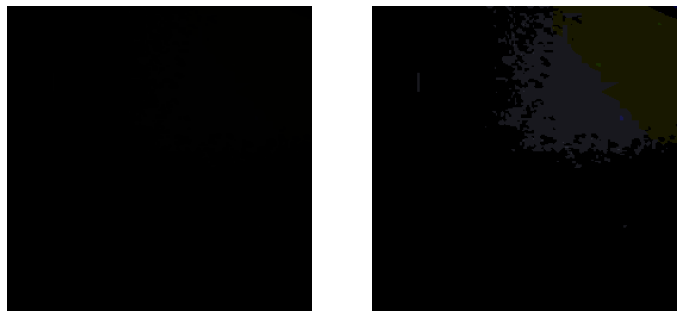

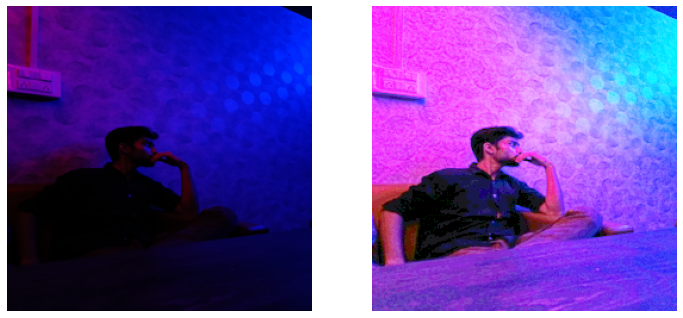

<Figure size 432x288 with 0 Axes>

In [49]:
for i, images in enumerate(zip(test_imgs, enhanced_imgs)):
    plot_results(images)
plt.savefig("sd")